# Example 11 - Loading timm Models
This notebook shows how users can load models from timm for IQ and spectogram data. 

----

# Import Libraries

In [1]:
# TorchSig
from torchsig.models.model_utils import convert_2d_model_to_1d
from torchsig.datasets.signal_classes import torchsig_signals
from torchsig.datasets.modulations import ModulationsDataset
from torchsig.datasets.wideband import WidebandModulationsDataset
from torchsig.utils.writer import DatasetCreator
from torchsig.transforms.target_transforms import DescToClassIndex, DescToBBoxDict
from torchsig.transforms.transforms import (
    RandomPhaseShift,
    Normalize,
    Compose,  
    ComplexTo2D,
    Spectrogram,
    SpectrogramImage
)
from torchsig.datasets.torchsig_narrowband import TorchSigNarrowband
from torchsig.datasets.torchsig_wideband import TorchSigWideband

# Third Party
from torch.nn import Linear
import timm
from torchinfo import summary
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Built-In
import os

Ensure your model name and version matches what timm supports. List models that timm supports with `timm.list_models()` method.

In [2]:
print(f"Total timm models = {len(timm.list_models())}\n")
print(f"Total timm pretrained models = {len(timm.list_pretrained())}\n")

Total timm models = 1170

Total timm pretrained models = 1525



# IQ Data Example

### Create Test Datasets for IQ Data

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
root = "./datasets/11_example"
num_workers = 8
seed = 1234567890
class_list = torchsig_signals.class_list
num_classes = len(class_list)

ds = ModulationsDataset(
    level = 2,
    num_samples = num_classes,
    num_iq_samples = 512**2,
    eb_no = False,
    use_class_idx = True,
    include_snr = True
)

os.makedirs(root, exist_ok=True)

creator = DatasetCreator(
    ds,
    seed = seed,
    path = f"{root}/narrowband_impaired_val",
    num_workers = num_workers,
)

creator.create()

0it [00:00, ?it/s]

1it [00:31, 31.26s/it]


Class Name: ofdm-64


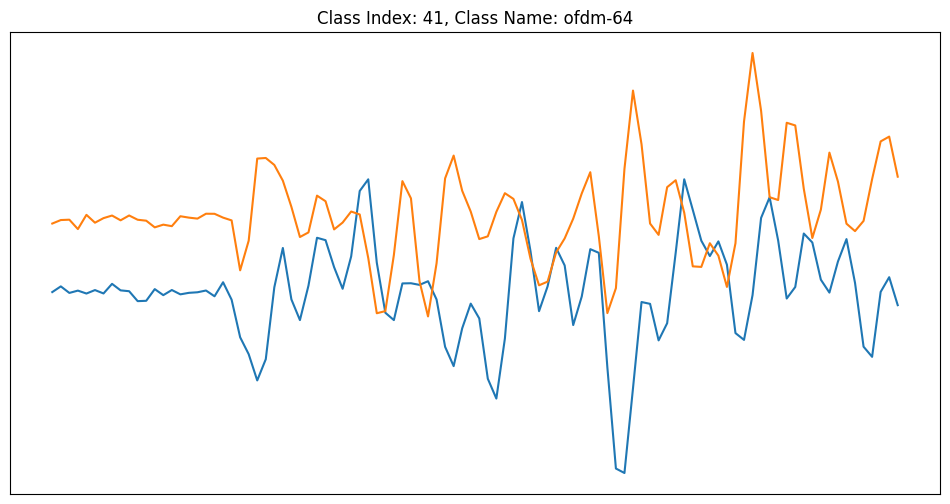

In [4]:
transform = Compose([
    RandomPhaseShift(phase_offset=(-1, 1)),
    Normalize(norm=np.inf),
    ComplexTo2D(),
])

target_transform = DescToClassIndex(class_list=class_list)


test_narrowband = TorchSigNarrowband(
    root,
    train = False,
    impaired = True,
    transform = transform,
    target_transform = target_transform,
    use_signal_data = True,
)

test_data_numpy, test_target = test_narrowband[0]
figure = plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.plot(test_data_numpy[0][:100])
plt.plot(test_data_numpy[1][:100])
plt.xticks([])
plt.yticks([])
plt.title(f"Class Index: {test_target}, Class Name: {class_list[test_target]}")
print(f"Class Name: {class_list[test_target]}")

# convert data as tensor, and put on same device as model, add batch dimension
test_data = torch.from_numpy(test_data_numpy).to(device).unsqueeze(0)
test_data = test_data.to(torch.float32)

### Test a DenseNet model

In [5]:
print(f"Total DenseNet models = {len(timm.list_models('*densenet*'))}")
timm.list_models('*densenet*')

Total DenseNet models = 6


['densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264d',
 'densenetblur121d']

We have provided a `convert_2d_model_to_1d()` helper function to covert any 2D models to 1D for 2 channel IQ data.

In [6]:
model_name = 'densenet121' # efficientnet_b0, xcit_nano_12_p16_224
num_classes = len(torchsig_signals.class_list)
in_channels = 2 # one for Real, another for Imaginary
# model arguments, varies from model to model
# for DenseNet:
drop_rate = 0.3

model = convert_2d_model_to_1d(
    timm.create_model(
        model_name,
        num_classes = num_classes,
        in_chans = in_channels,
        drop_rate = drop_rate,
        pretrained = True
    )
)
model.classifier = Linear(model.classifier.in_features, num_classes)
model.to(device)

summary(model)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (norm0): GBN1d(
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool0): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (denselayer1): DenseLayer(
        (norm1): GBN1d(
          (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv1): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
        (norm2): GBN1d(
          (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv2): Conv1d(128, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      )
      (denselayer2): DenseLayer(
        (norm1): GBN1d(
          (bn): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (con

In [7]:
pred = model(test_data)
result = torch.argmax(pred, dim=1).cpu().item()

# compare results
print(f"Model Prediction = {result} | {class_list[result]}")
print(f"Actual = {test_target} | {class_list[test_target]}")

Model Prediction = 58 | lfm_data
Actual = 41 | ofdm-64


# Spectrogram Data Example

Note: does not require conversion from 2D to 1D, ad 2D models are needed for image domain.

### Create Test Dataet for Spectrogram Data

Spectrogram: (512, 512, 3)


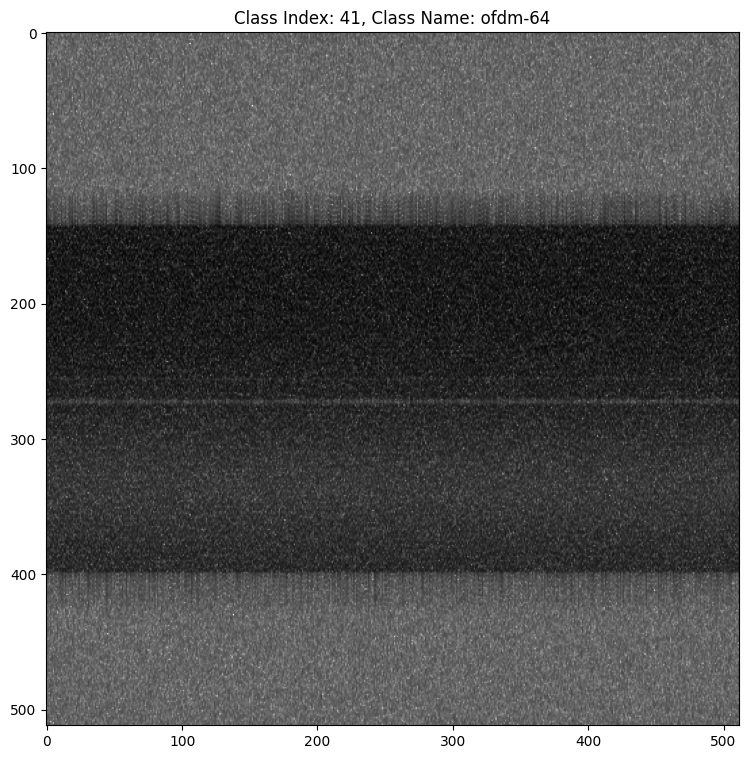

In [8]:
transform = Compose([
    Spectrogram(nperseg=512, noverlap=0, nfft=512, mode='psd'),
    Normalize(norm=np.inf, flatten=True),
    SpectrogramImage(), 
])

target_transform = DescToClassIndex(class_list=class_list)

test_narrowband = TorchSigNarrowband(
    root,
    train = False,
    impaired = True,
    transform = transform,
    target_transform = target_transform,
    use_signal_data = True,
)

test_data_numpy, test_target = test_narrowband[0]


full_width, full_height, _ = test_data_numpy.shape
figure = plt.figure(figsize=(9, 9))
ax = plt.subplot(1, 1, 1)
ax.imshow(test_data_numpy)
plt.title(f"Class Index: {test_target}, Class Name: {class_list[test_target]}")

test_data = torch.from_numpy(test_data_numpy).to(torch.float32).unsqueeze(0).to(device)
print(f"Spectrogram: {test_data_numpy.shape}")

### Test an EfficientNet Model

In [9]:
print(f"Total EfficientNet models = {len(timm.list_models('*efficientnet*'))}")
timm.list_models('*efficientnet*')[:10] # list first 10 models

Total EfficientNet models = 76


['efficientnet_b0',
 'efficientnet_b0_g8_gn',
 'efficientnet_b0_g16_evos',
 'efficientnet_b0_gn',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_g8_gn']

In [10]:
model_name = 'efficientnet_b2'
num_classes = len(torchsig_signals.class_list)
in_channels = 512 # image width dimension

# model arguments, varies from model to model
# for EfficientNet:
drop_path_rate = 0.2
drop_rate = 0.3

model = timm.create_model(
    model_name,
    num_classes = num_classes,
    in_chans = in_channels,
    drop_rate = drop_rate,
    pretrained = True
)
model.classifier = Linear(model.classifier.in_features, num_classes)
model.to(device)

summary(model)
model.eval()

EfficientNet(
  (conv_stem): Conv2d(512, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

In [11]:
pred = model(test_data)
result = torch.argmax(pred, dim=1).cpu().item()

# # compare results
print(f"Model Prediction = {result} | {class_list[result]}")
print(f"Actual = {test_target} | {class_list[test_target]}")

Model Prediction = 48 | ofdm-600
Actual = 41 | ofdm-64
